<a href="https://colab.research.google.com/github/ElinaGaiduk/ImageInpaintingPconv/blob/main/ImageInpaintingP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/ElinaGaiduk/ImageInpaintingPconv.git

Cloning into 'ImageInpaintingPconv'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), 4.50 KiB | 658.00 KiB/s, done.


In [4]:
%cd ImageInpaintingPconv/

/content/ImageInpaintingPconv/ImageInpaintingPconv


In [5]:
%%capture
!pip install tensorflow-gpu==2.0

In [6]:
import os #функции для взаимодействия с операционной системой
import cv2 #функции для работы с изображениями и видео.
import numpy as np #библиотека для выполнения вычислений на многомерных массивах и предоставляет множество функций для работы с числовыми данными.
import tensorflow as tf #инструменты для создания и обучения нейронных сетей
from tensorflow import keras #API для построения и обучения моделей глубокого обучения

import matplotlib.pyplot as plt #функции для создания графиков и визуализации данных.
%matplotlib inline

from mpl_toolkits.axes_grid1 import ImageGrid #способ отображения нескольких изображений в виде сетки.

In [7]:
# Загружаем Cifar 10 Dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

170498071/170498071 [==============================] - 4s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


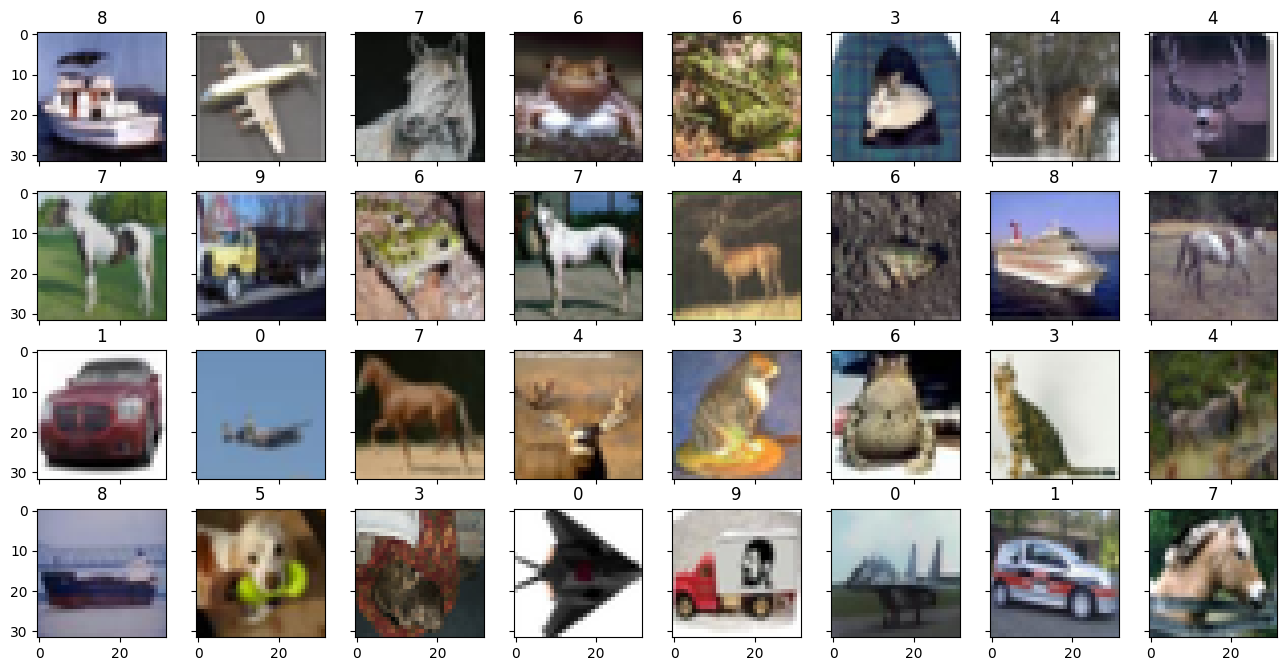

In [8]:
# Получаем случайные 32 изображения в качестве образцов визуализации
random_indices = np.random.choice(len(x_train), size=32, replace=False)
sample_images = x_train[random_indices]
sample_labels = y_train[random_indices]

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 8), 
                 axes_pad=0.3,  
                 )

for ax, image, label in zip(grid, sample_images, sample_labels):
  ax.imshow(image)
  ax.set_title(label[0])

plt.show()

In [9]:
# Основа: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.
class createAugment(keras.utils.Sequence):
  'Генерирует данные для обучения'
  def __init__(self, X, y, batch_size=32, dim=(32, 32), n_channels=3, shuffle=True):
      'Инициализация конструктора'
      self.batch_size = batch_size 
      self.X = X 
      self.y = y
      self.dim = dim
      self.n_channels = n_channels
      self.shuffle = shuffle
      
      self.on_epoch_end()

  def __len__(self):
      'Количество батчей в эпоху'
      return int(np.floor(len(self.X) / self.batch_size))

  def __getitem__(self, index):
      'Генерация одного батча'
      # Генерация индексов батча
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Генерация данных
      X_inputs, y_output = self.__data_generation(indexes)
      return X_inputs, y_output

  def on_epoch_end(self):
      'Обновляет индексы после каждой эпохи'
      self.indexes = np.arange(len(self.X))
      if self.shuffle:
          np.random.shuffle(self.indexes)

  def __data_generation(self, idxs):
    # Masked_images - матрица замаскированных изображений, используемых в качестве входных данных
    Masked_images = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # замаскированное изображение
    # Mask_batch - матрица двоичных масок, используемых в качестве входных данных
    Mask_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # двоичные маски
    # y_batch - матрица исходных изображений, используемых для вычисления ошибок из реконструированных изображений
    y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # оригинальное изображение
    

    # Итерация по случайным индексам
    for i, idx in enumerate(idxs):
      image_copy = self.X[idx].copy()
  
      # Получение маски, связанной с изображением
      masked_image, mask = self.__createMask(image_copy)
      
      Masked_images[i,] = masked_image/255
      Mask_batch[i,] = mask/255
      y_batch[i] = self.y[idx]/255

    # Возвращение маски, так как этого требует частичная свертка
    return [Masked_images, Mask_batch], y_batch

  def __createMask(self, img):
    # Подготовка матрицы маски
    mask = np.full((32,32,3), 255, np.uint8) # Белый фон
    for _ in range(np.random.randint(1, 10)):
      # Получаем случайные позиции x для начала линии
      x1, x2 = np.random.randint(1, 32), np.random.randint(1, 32)
      # Получаем случайные позиции y для начала линии
      y1, y2 = np.random.randint(1, 32), np.random.randint(1, 32)
      # Получаем случайную толщину линии
      thickness = np.random.randint(1, 3)
      # Рисуем черную линию на белой маске
      cv2.line(mask,(x1,y1),(x2,y2),(0,0,0),thickness)

    # Накладываем маску на изображение
    masked_image = img.copy()
    masked_image[mask==0] = 255

    return masked_image, mask

In [10]:
# Подготавливаем обучающий и тестовый генератор пар маска-изображение
traingen = createAugment(x_train, x_train)
testgen = createAugment(x_test, x_test, shuffle=False)

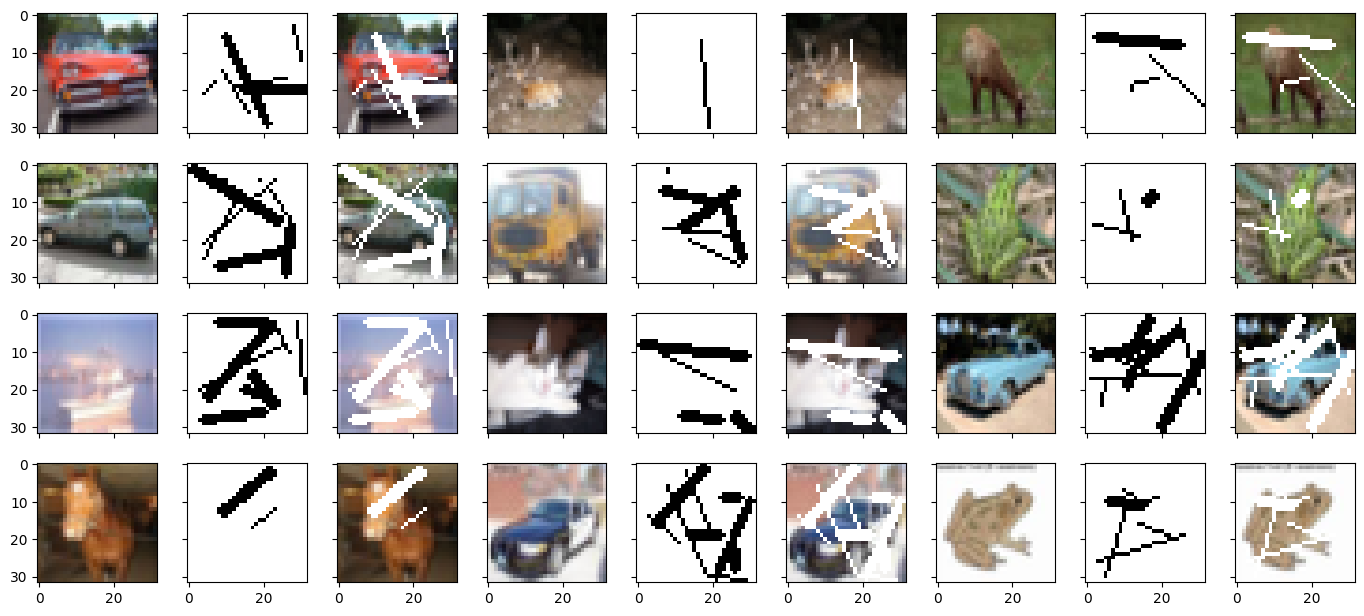

In [11]:
# Оригинальное изображение | Сгенерированная маска | Изображение с маской

# Примеры
sample_idx = 90 

[masked_images, masks], sample_labels = traingen[sample_idx]
sample_images = [None]*(len(masked_images)+len(masks)+len(sample_labels))
sample_images[::3] = sample_labels
# маски[]
sample_images[1::3] = masks
sample_images[2::3] = masked_images

fig = plt.figure(figsize=(17., 8.))
grid = ImageGrid(fig, 111,  
                 nrows_ncols=(4, 9),  
                 axes_pad=0.3,  
                 )

for ax, image in zip(grid, sample_images):
  ax.imshow(image)

plt.show()

In [12]:
# В репозитории на github представлена реализация PConv2D
from Pconv_layer import PConv2D

In [13]:
# Метрика
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

In [14]:
class InpaintingModel:
  '''
  Используем UNet модель
  '''
  def prepare_model(self, input_size=(32,32,3)):
    input_image = keras.layers.Input(input_size)
    input_mask = keras.layers.Input(input_size, name='encoder_input')
  
    conv1, mask1, conv2, mask2 = self.__encoder_layer(32, input_image, input_mask, ['conv1', 'conv2'])
    conv3, mask3, conv4, mask4 = self.__encoder_layer(64, conv2, mask2, ['conv3', 'conv4'])
    conv5, mask5, conv6, mask6 = self.__encoder_layer(128, conv4, mask4, ['conv5', 'conv6'])
    conv7, mask7, conv8, mask8 = self.__encoder_layer(256, conv6, mask6, ['conv7', 'encoder_output'])

    conv9, mask9, conv10, mask10 = self.__decoder_layer(256, 128, conv8, mask8, conv7, mask7, ['conv9', 'conv10'])
    conv11, mask11, conv12, mask12 = self.__decoder_layer(128, 64, conv10, mask10, conv5, mask5, ['conv11', 'conv12'])
    conv13, mask13, conv14, mask14 = self.__decoder_layer(64, 32, conv12, mask12, conv3, mask3, ['conv13', 'conv14'])
    conv15, mask15, conv16, mask16 = self.__decoder_layer(32, 3, conv14, mask14, conv1, mask1, ['conv15', 'decoder_output'])

    outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv16)

    return keras.models.Model(inputs=[input_image, input_mask], outputs=[outputs])
    
  def __encoder_layer(self, filters, in_layer, in_mask, names):
    conv1, mask1 = PConv2D(32, (3,3), strides=1, padding='same', name=names[0])([in_layer, in_mask])
    conv1 = keras.activations.relu(conv1)

    conv2, mask2 = PConv2D(32, (3,3), strides=2, padding='same', name=names[1])([conv1, mask1])
    #conv2 = keras.layers.BatchNormalization()(conv2, training=True)
    conv2 = keras.activations.relu(conv2)

    return conv1, mask1, conv2, mask2

  def __decoder_layer(self, filter1, filter2, in_img, in_mask, share_img, share_mask, names):
    up_img = keras.layers.UpSampling2D(size=(2,2))(in_img)
    up_mask = keras.layers.UpSampling2D(size=(2,2))(in_mask)
    concat_img = keras.layers.Concatenate(axis=3)([share_img, up_img])
    concat_mask = keras.layers.Concatenate(axis=3)([share_mask, up_mask])

    conv1, mask1 = PConv2D(filter1, (3,3), padding='same', name=names[0])([concat_img, concat_mask])
    conv1 = keras.activations.relu(conv1)

    conv2, mask2 = PConv2D(filter2, (3,3), padding='same', name=names[1])([conv1, mask1])
    #conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.activations.relu(conv2)

    return conv1, mask1, conv2, mask2

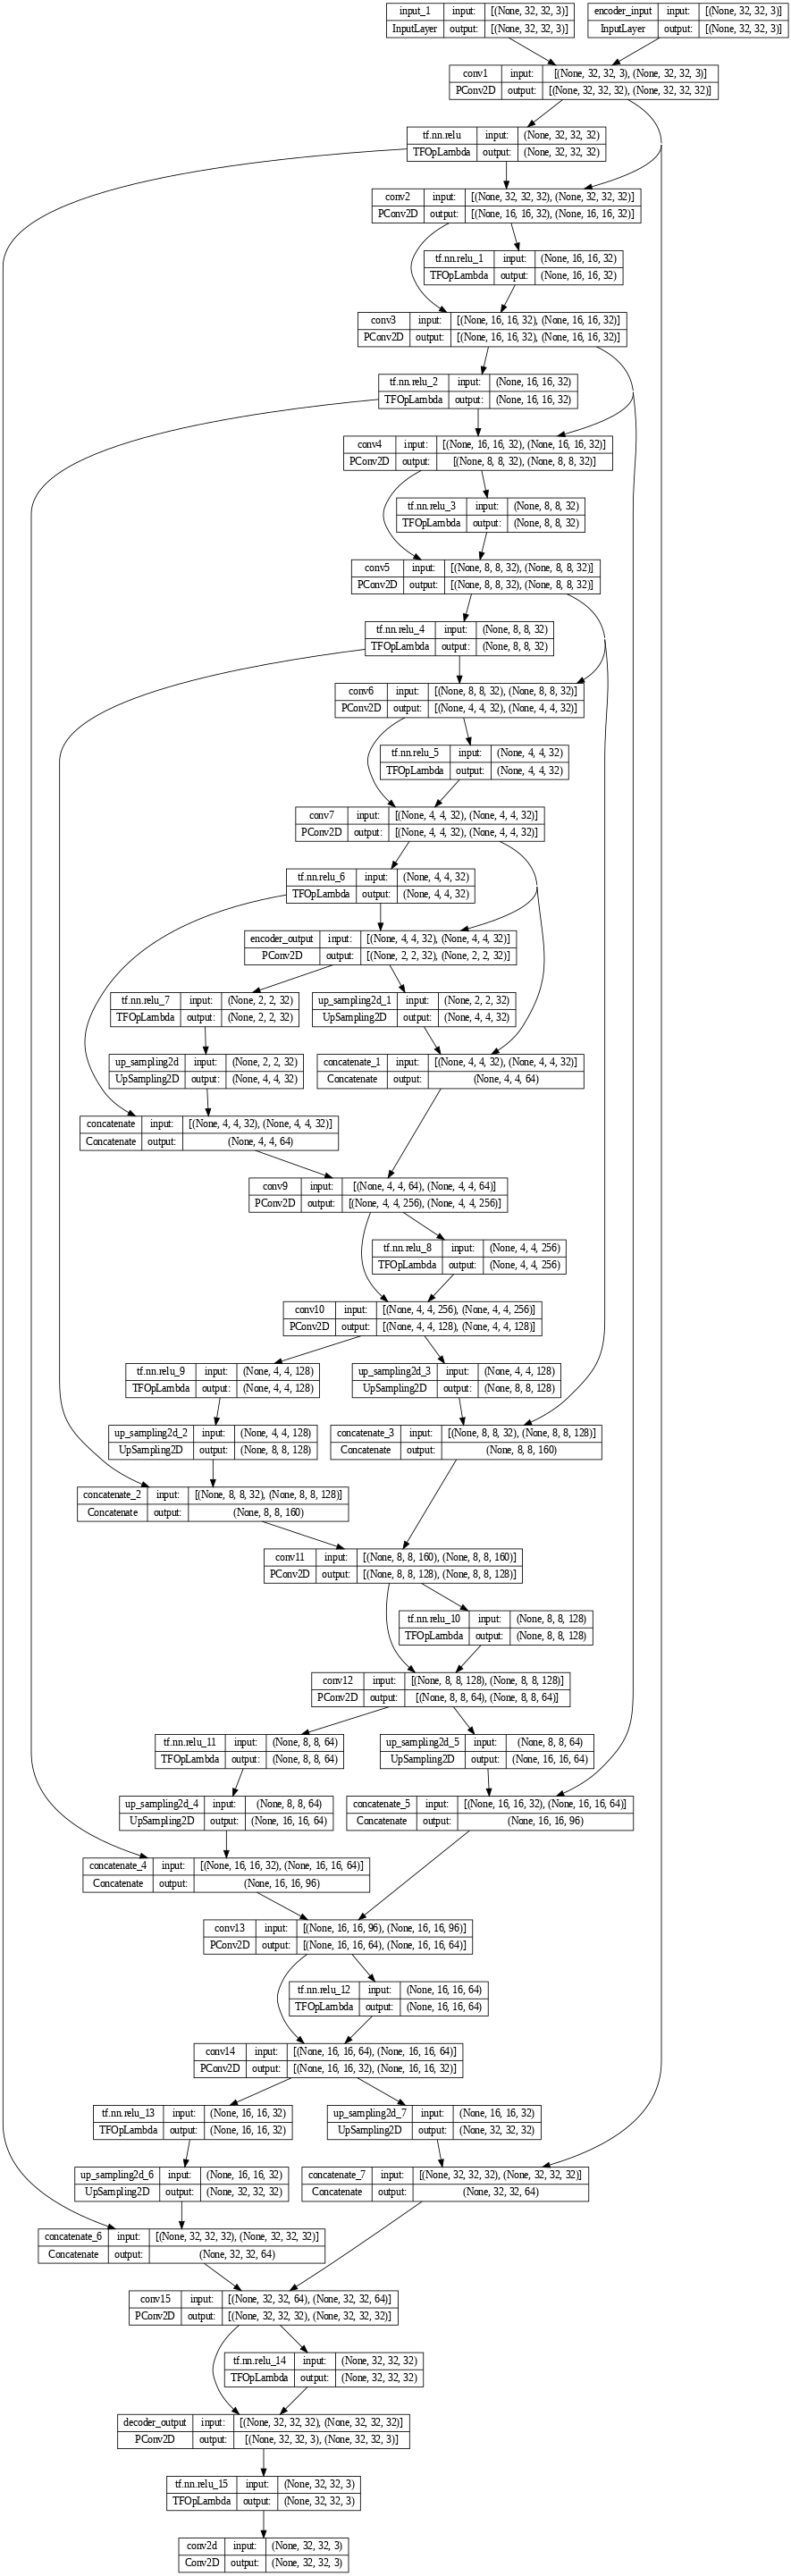

In [15]:
keras.backend.clear_session()
model = InpaintingModel().prepare_model()
# model.summary()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[dice_coef])
keras.utils.plot_model(model, show_shapes=True, dpi=60)

In [16]:
class PredictionLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super(PredictionLogger, self).__init__()

    def on_epoch_end(self, logs, epoch):
        sample_idx = 54
        [masked_images, masks], sample_labels = testgen[sample_idx]  
        
        # Инициализация пустых списков, хранящих промежуточные результаты
        m_images = []
        binary_masks = []
        predictions = []
        labels = []
        
        # Итерация по пакету для i в диапазоне (32)
        for i in range(32):
          inputs = [masked_images[i].reshape((1,)+masked_images[i].shape), masks[i].reshape((1,)+masks[i].shape)]
          impainted_image = model.predict(inputs)

        # Добавляем результаты в соответствующие списки
          m_images.append(masked_images[i])
          binary_masks.append(masks[i])
          predictions.append(impainted_image.reshape(impainted_image.shape[1:]))
          labels.append(sample_labels[i])

In [ ]:
_ = model.fit_generator(traingen, validation_data=testgen, 
          epochs=20, 
          steps_per_epoch=len(traingen), 
          validation_steps=len(testgen),
          use_multiprocessing=True,
          callbacks=[PredictionLogger()])

In [ ]:
# Поврежденное изображение | Сгенерированная маска | Восстановленная фотография| Оригинальное изображение

# Примеры
rows = 10
sample_idx = 54
[masked_images, masks], sample_labels = testgen[sample_idx]

fig, axs = plt.subplots(nrows=rows, ncols=4, figsize=(8, 2*rows))

for i in range(32):
  inputs = [masked_images[i].reshape((1,)+masked_images[i].shape), masks[i].reshape((1,)+masks[i].shape)]
  impainted_image = model.predict(inputs)
  axs[i][0].imshow(masked_images[i])
  axs[i][1].imshow(masks[i])
  axs[i][2].imshow(impainted_image.reshape(impainted_image.shape[1:]))
  axs[i][3].imshow(sample_labels[i])
  
plt.show()